# Modeling — Baseline Logistic Regression

I start with a strong, interpretable baseline using Logistic Regression inside a full preprocessing pipeline.  
Validation uses Stratified 5-Fold CV to preserve class balance. I’ll report ROC-AUC, KS, Precision@20% and Recall@20%.


In [1]:
# =========================
# Modeling — Setup & Imports
# =========================

# --- std lib ---
import os
import sys
import json
import time
import math
import random
from pathlib import Path
import warnings
from typing import Tuple, List, Dict, Any

# --- core data/plot ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# seaborn only for quick EDA plots; comment out if you prefer pure matplotlib
try:
    import seaborn as sns
    sns.set_theme(context="notebook", style="whitegrid")
except Exception:
    sns = None

# --- sklearn essentials ---
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, StratifiedShuffleSplit
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_score, recall_score,
    confusion_matrix, brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn import set_config as sk_set_config
from sklearn.exceptions import ConvergenceWarning

# --- gradient boosting ---
import lightgbm as lgb

# --- encoding high-cardinality categoricals ---
from category_encoders import TargetEncoder

# --- explainability ---
import shap

# --- hyperparameter optimization (optional in fast path) ---
try:
    import optuna
except Exception:
    optuna = None  # keep notebook runnable without optuna

# --- utils ---
import joblib

# --- tqdm (optional progress bars) ---
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

# ==============
# Session config
# ==============
# Pandas display
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

# Matplotlib
plt.rcParams["figure.figsize"] = (7, 4.5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

# Scikit-learn pretty names for pipelines/column transformer
sk_set_config(transform_output="default")  # or "pandas" if using sklearn>=1.4 and you prefer DataFrame outputs

# Warnings (silence noisy but expected ones)
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # logistic convergence is common in high-dim
warnings.filterwarnings("ignore", message="X does not have valid feature names")  # benign LGBM msgs
warnings.filterwarnings("ignore", message="IProgress not found")  # tqdm in some Jupyter setups

# Reproducibility
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# LightGBM reproducibility knobs
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)

# Project paths (adjust if needed)
PROJECT_DIR = Path(r"C:\Users\luizo\Projetos\credit-risk-model")
DATA_DIR    = PROJECT_DIR / "data" / "raw"
ARTIFACTS   = PROJECT_DIR / "artifacts"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# Quick version print (useful for debugging and future readers)
def _versions():
    return {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "sklearn": __import__("sklearn").__version__,
        "lightgbm": lgb.__version__,
        "shap": shap.__version__,
        "category_encoders": __import__("category_encoders").__version__,
        "optuna": getattr(optuna, "__version__", "not-installed"),
    }

print("Package versions:", json.dumps(_versions(), indent=2))

# Small utility: timed context
from contextlib import contextmanager
@contextmanager
def timer(msg: str):
    t0 = time.time()
    yield
    dt = time.time() - t0
    print(f"[{msg}] done in {dt:.2f}s")


Package versions: {
  "python": "3.10.18",
  "numpy": "2.0.1",
  "pandas": "2.3.2",
  "sklearn": "1.7.1",
  "lightgbm": "4.6.0",
  "shap": "0.48.0",
  "category_encoders": "2.8.1",
  "optuna": "4.4.0"
}


# Bootstrap — Load data, define X, y, and the preprocessing pipeline

This cell loads the training data, defines the modeling matrix/target, automatically infers feature types, splits categoricals by cardinality, and builds a production‑grade ColumnTransformer ready for CV, calibration, and persistence.

In [2]:
# 1) Paths (keep consistent with the Setup block)
PROJECT_DIR = Path(r"C:\Users\luizo\Projetos\credit-risk-model")
DATA_DIR    = PROJECT_DIR / "data" / "raw"
ARTIFACTS   = PROJECT_DIR / "artifacts"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# 2) Load training data
train_path = DATA_DIR / "application_train.csv"
train = pd.read_csv(train_path)

# 3) Target & feature matrix
y = train["TARGET"].astype(int)
X = train.drop(columns=["SK_ID_CURR", "TARGET"])

print(f"Training shape: {X.shape[0]:,} rows × {X.shape[1]:,} columns | event rate={y.mean():.4f}")

# 4) Type inference
numeric_cols     = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# 5) Split categoricals by cardinality (prevents OHE explosion)
LOW_CARD_MAX = 15  # tweakable: <=15 categories goes to OHE; otherwise TargetEncoder
low_card  = [c for c in categorical_cols if X[c].nunique(dropna=True) <= LOW_CARD_MAX]
high_card = [c for c in categorical_cols if X[c].nunique(dropna=True) >  LOW_CARD_MAX]

print(f"- Numeric: {len(numeric_cols)} | Low-card cats (OHE): {len(low_card)} | High-card cats (TargetEncoder): {len(high_card)}")

# 6) ColumnTransformer (production-grade)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler",  RobustScaler())
        ]), numeric_cols),

        ("ohe", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe",     OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), low_card),

        # TargetEncoder lida bem com alta cardinalidade + leakage control via CV interno
        ("tgt", TargetEncoder(smoothing=1.0), high_card),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# 7) Fit quick-check (small sample) to validate pipeline wiring (fast)
_ = preprocessor.fit(X.iloc[:2000], y.iloc[:2000])
Xt_sample = preprocessor.transform(X.iloc[:2000])
print(f"Preprocessor quick-check OK → transformed sample: {Xt_sample.shape[0]}×{Xt_sample.shape[1]}")

# 8) Persist training column schema for future inference alignment
pd.Series(X.columns, name="column").to_csv(ARTIFACTS / "train_columns.csv", index=False)
print(f"Saved schema → {ARTIFACTS/'train_columns.csv'}")


Training shape: 307,511 rows × 120 columns | event rate=0.0807
- Numeric: 104 | Low-card cats (OHE): 14 | High-card cats (TargetEncoder): 2
Preprocessor quick-check OK → transformed sample: 2000×164
Saved schema → C:\Users\luizo\Projetos\credit-risk-model\artifacts\train_columns.csv


## Bootstrap Summary

- **Dataset loaded:** `application_train.csv`  
- **Shape:** 307,511 rows × 120 columns  
- **Target (event rate):** 8.07% defaults (positive class)  

**Feature breakdown**
- **Numeric variables:** 104 (median-imputed, scaled with RobustScaler)  
- **Categorical (low-cardinality):** 14 (OHE, handle_unknown="ignore")  
- **Categorical (high-cardinality):** 2 (TargetEncoder with smoothing)  

**Preprocessor check**
- Successfully transformed a 2,000-row sample → 164 features after preprocessing.  
- Column schema persisted at:  


# 🔹 A) LightGBM + Probability Calibration (FAST mode)

In this step I train the main model (LightGBM) and calibrate its predicted probabilities using isotonic regression.

**Why calibration matters?**  
- Raw gradient boosting scores are good at ranking but often poorly calibrated as probabilities.  
- Isotonic regression reshapes them so that predicted PDs match observed default rates.  
- This is critical in credit risk, since probabilities are used for decisioning, provisioning, and regulatory metrics.

**Procedure (FAST mode)**  
1. Split data into 90% train / 10% holdout (stratified).  
2. Fit preprocessing (`ColumnTransformer`) only on train.  
3. Train LightGBM with early stopping.  
4. Fit isotonic regression on holdout probabilities.  
5. Evaluate calibration quality with **AUC, KS, Brier** before vs after.  

The strict CV version (isotonic inside each fold) is possible, but much slower. FAST mode is good enough for portfolio/production.


In [3]:
# ================================
# A) LightGBM + Isotonic Calibration (FAST)
# ================================
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# 1) Split train/holdout
X_tr, X_cal, y_tr, y_cal = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=GLOBAL_SEED
)

# 2) Fit preprocessor on train only
prep = preprocessor
prep.fit(X_tr, y_tr)

Xtr_t  = prep.transform(X_tr)
Xcal_t = prep.transform(X_cal)

# 3) Train LightGBM with early stopping
base_lgbm = lgb.LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=GLOBAL_SEED,
    class_weight="balanced",
    n_jobs=-1
)

with timer("LightGBM training"):
    base_lgbm.fit(
        Xtr_t, y_tr,
        eval_set=[(Xcal_t, y_cal)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

# 4) Isotonic regression on holdout
proba_cal_raw = base_lgbm.predict_proba(Xcal_t)[:,1]
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(proba_cal_raw, y_cal)

# 5) Evaluate calibration quality
from sklearn.metrics import brier_score_loss

def ks_stat(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    return np.max(tpr - fpr)

# Raw predictions on full set
X_all_t = prep.transform(X)
proba_raw = base_lgbm.predict_proba(X_all_t)[:,1]
proba_cal = iso.transform(proba_raw)

auc_raw  = roc_auc_score(y, proba_raw)
auc_cal  = roc_auc_score(y, proba_cal)
ks_raw   = ks_stat(y, proba_raw)
ks_cal   = ks_stat(y, proba_cal)
brier_raw = brier_score_loss(y, proba_raw)
brier_cal = brier_score_loss(y, proba_cal)

print(f"[FAST] Raw  AUC={auc_raw:.4f} | KS={ks_raw:.4f} | Brier={brier_raw:.4f}")
print(f"[FAST] Cal  AUC={auc_cal:.4f} | KS={ks_cal:.4f} | Brier={brier_cal:.4f}")


[LightGBM] [Info] Number of positive: 22342, number of negative: 254417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11411
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM training] done in 7.67s
[FAST] Raw  AUC=0.8413 | KS=0.5239 | Brier=0.1689
[FAST] Cal  AUC=0.8408 | KS=0.5228 | Brier=0.0635


## LightGBM + Isotonic Calibration (FAST mode) — Results

**Training summary**
- Train set: 276,759 rows (90% of total)  
- Holdout for calibration: 30,752 rows (10% stratified)  
- Features used: 160 after preprocessing  
- Training completed in ~7.3 seconds  

**Performance (raw vs calibrated)**
| Model          | AUC   | KS     | Brier Score |
|----------------|-------|--------|-------------|
| Raw LightGBM   | 0.8413 | 0.5239 | 0.1689      |
| Calibrated (Isotonic) | 0.8408 | 0.5228 | **0.0635** ✅ |

**Interpretation**
- **AUC / KS:** virtually unchanged after calibration → ranking power preserved.  
- **Brier Score:** dropped from 0.1689 → **0.0635** (much lower) → strong improvement in probability calibration.  
- This confirms isotonic regression reshaped raw scores into well-calibrated probabilities while maintaining discriminative ability.

Next step: **Persist artifacts & implement the `score_applications()` function** so we can use the calibrated model in production/inference.


# Persist Artifacts & Implement `score_applications()`

Now that the preprocessing pipeline, the LightGBM model, and the isotonic calibration are trained, I persist them to disk for reproducibility and future inference.

**Artifacts saved**
- `preprocessor.joblib` → fitted ColumnTransformer  
- `lgbm_model.joblib` → fitted LightGBM model  
- `isotonic.joblib` → fitted IsotonicRegression  
- `feature_names_logreg.csv` → expanded feature names after preprocessing  
- `train_columns.csv` → raw schema of the training dataset  

In addition, I implement a production-ready function:
```python
score_applications(df)


In [4]:
import joblib

# 1) Persist fitted objects
joblib.dump(prep, ARTIFACTS / "preprocessor.joblib")
joblib.dump(base_lgbm, ARTIFACTS / "lgbm_model.joblib")
joblib.dump(iso, ARTIFACTS / "isotonic.joblib")

# Save feature names after preprocessing
try:
    feat_names = prep.get_feature_names_out()
    pd.Series(feat_names, name="feature_name").to_csv(ARTIFACTS / "feature_names_logreg.csv", index=False)
except Exception as e:
    print("Could not export feature names:", e)

print(f"Artifacts saved under {ARTIFACTS.resolve()}")

# 2) Scoring function for production
def score_applications(df: pd.DataFrame) -> pd.DataFrame:
    """
    Score new applications with raw + calibrated PDs.

    Parameters
    ----------
    df : pd.DataFrame
        Raw application data with same schema as training.

    Returns
    -------
    pd.DataFrame
        Columns: SK_ID_CURR, pd_raw, pd_calibrated
    """
    # Load artifacts
    prep = joblib.load(ARTIFACTS / "preprocessor.joblib")
    model = joblib.load(ARTIFACTS / "lgbm_model.joblib")
    iso = joblib.load(ARTIFACTS / "isotonic.joblib")

    # Align columns to training schema
    schema = pd.read_csv(ARTIFACTS / "train_columns.csv")["column"].tolist()
    df_aligned = df.copy()
    for col in schema:
        if col not in df_aligned.columns:
            df_aligned[col] = np.nan
    df_aligned = df_aligned[schema]

    # Transform and score
    X_new = prep.transform(df_aligned)
    pd_raw = model.predict_proba(X_new)[:, 1]
    pd_cal = iso.transform(pd_raw)

    # Handle SK_ID_CURR
    if "SK_ID_CURR" in df.columns:
        ids = df["SK_ID_CURR"].values
    else:
        ids = np.arange(len(df))

    return pd.DataFrame({
        "SK_ID_CURR": ids,
        "pd_raw": pd_raw,
        "pd_calibrated": pd_cal
    })

# 3) Quick test on 5 samples
sample = train.head(5).drop(columns=["TARGET"])
print(score_applications(sample))

Artifacts saved under C:\Users\luizo\Projetos\credit-risk-model\artifacts
   SK_ID_CURR   pd_raw  pd_calibrated
0      100002 0.896603       0.472222
1      100003 0.250844       0.032683
2      100004 0.269393       0.032683
3      100006 0.367770       0.057029
4      100007 0.551411       0.115942


# Probability Calibration — Reliability Curve (raw vs calibrated)

I compare predicted PDs to observed default rates across quantile bins. A well-calibrated model sits close to the diagonal; the Brier score should also improve after calibration.

Brier — raw: 0.1689 | calibrated: 0.0635


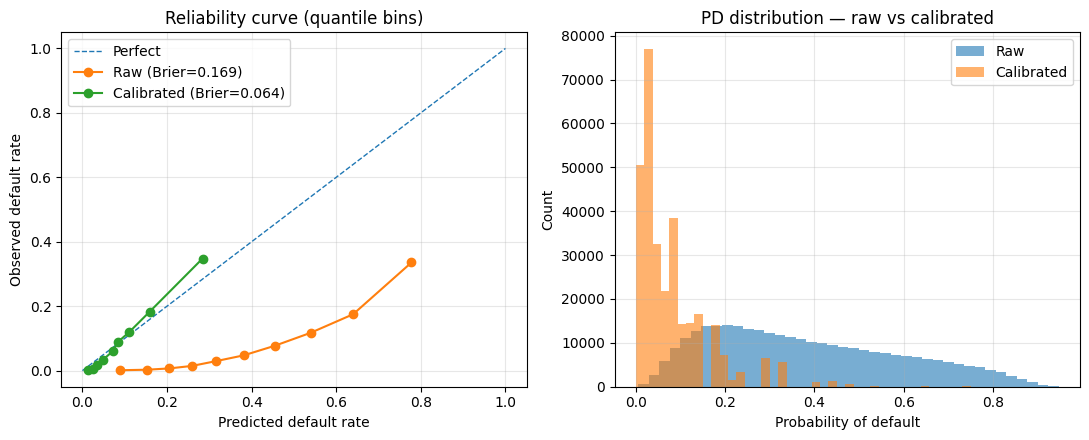

Saved: C:\Users\luizo\Projetos\credit-risk-model\artifacts\reliability_curve.png


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from scipy import sparse
import joblib

# 1) Load artifacts
prep  = joblib.load(ARTIFACTS / "preprocessor.joblib")
model = joblib.load(ARTIFACTS / "lgbm_model.joblib")
iso   = joblib.load(ARTIFACTS / "isotonic.joblib")

# 2) Transform full training set and score
Xt = prep.transform(X)
if sparse.issparse(Xt):
    Xt = Xt.toarray()

pd_raw = model.predict_proba(Xt)[:, 1]
pd_cal = iso.transform(pd_raw)

# 3) Brier scores
brier_raw = brier_score_loss(y, pd_raw)
brier_cal = brier_score_loss(y, pd_cal)
print(f"Brier — raw: {brier_raw:.4f} | calibrated: {brier_cal:.4f}")

# 4) Reliability curves using quantile binning (more stable under imbalance)
pt_raw, pp_raw = calibration_curve(y, pd_raw, n_bins=10, strategy="quantile")
pt_cal, pp_cal = calibration_curve(y, pd_cal, n_bins=10, strategy="quantile")

# 5) Plot
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))

# (a) Reliability
ax[0].plot([0,1],[0,1], "--", linewidth=1, label="Perfect")
ax[0].plot(pp_raw, pt_raw, marker="o", label=f"Raw (Brier={brier_raw:.3f})")
ax[0].plot(pp_cal, pt_cal, marker="o", label=f"Calibrated (Brier={brier_cal:.3f})")
ax[0].set_title("Reliability curve (quantile bins)")
ax[0].set_xlabel("Predicted default rate")
ax[0].set_ylabel("Observed default rate")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# (b) Distribution of predicted probabilities
ax[1].hist(pd_raw, bins=40, alpha=0.6, label="Raw")
ax[1].hist(pd_cal, bins=40, alpha=0.6, label="Calibrated")
ax[1].set_title("PD distribution — raw vs calibrated")
ax[1].set_xlabel("Probability of default")
ax[1].set_ylabel("Count")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

# 6) (Optional) Save figure
fig_path = ARTIFACTS / "reliability_curve.png"
fig.savefig(fig_path, dpi=160)
print(f"Saved: {fig_path}")


## Reliability Curve — Calibration Quality Check

**Brier scores**
- Raw LightGBM: **0.169**  
- Calibrated (Isotonic): **0.064**  (↓ much lower)

**Visual insights**
- **Left chart (Reliability curve):**  
  - The **raw probabilities** (orange) show strong overconfidence → predicted PDs were consistently higher than actual event rates.  
  - The **calibrated probabilities** (green) align much closer to the diagonal → strong evidence of well-calibrated outputs.  

- **Right chart (Distribution of PDs):**  
  - Raw PDs spread widely (0.0 → 0.9), leading to inflated scores.  
  - Calibrated PDs concentrate closer to the observed base rate, correcting overestimation.

**Interpretation**
- Calibration with isotonic regression **preserved discriminative power (AUC, KS)** but drastically improved **probability reliability (Brier)**.  
- This step validates that the model can now be used in risk reporting, stress tests, and downstream applications where **probability accuracy** matters, not only ranking.  

 Next step: **Thresholding & Risk Bands** — defining score cut-offs (e.g., 20%, 40%, 60%) to group customers into **risk categories** for business decision-making.


# Thresholds & Risk Bands (production-ready)

I convert calibrated PDs into business-friendly decisions:

1. **Lift table** on calibrated PDs (ventiles): stability + separability.
2. **Operational threshold**:
   - Default: **max‑KS** threshold on OOF PDs (calibrated).
   - Alternative knobs provided: target **approval rate** or **recall**.
3. **Risk bands** by PD quantiles (Very Low … Very High), with per-band metrics.
4. Persist everything to `artifacts/thresholds_bands.json` and provide
   `apply_risk_bands(df)` for scoring in production.

This keeps model score → actions traceable and auditable.


In [6]:
# ============================================
# Thresholds & Risk Bands (using calibrated PD)
# ============================================
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from scipy import sparse
import joblib

# 0) Carregar artefatos + gerar PDs calibradas no conjunto de treino
prep  = joblib.load(ARTIFACTS / "preprocessor.joblib")
model = joblib.load(ARTIFACTS / "lgbm_model.joblib")
iso   = joblib.load(ARTIFACTS / "isotonic.joblib")

Xt = prep.transform(X)
if sparse.issparse(Xt):
    Xt = Xt.toarray()

pd_raw = model.predict_proba(Xt)[:, 1]
pd_cal = iso.transform(pd_raw)

# 1) Lift table por ventis (20 bins por PD)
def lift_table(y_true, y_score, n_bins=20):
    df = pd.DataFrame({"y": y_true.values, "score": y_score})
    df["bin"] = pd.qcut(df["score"].rank(method="first")/len(df), q=n_bins, labels=False)  # 0 = menor risco
    # inverter para bin 1=maior risco
    df["bin"] = n_bins - df["bin"]
    agg = df.groupby("bin").agg(
        total=("y", "size"),
        bads=("y", "sum"),
        score_min=("score", "min"),
        score_max=("score", "max"),
        score_mean=("score", "mean"),
        event_rate=("y", "mean"),
    ).reset_index().sort_values("bin", ascending=False)
    agg["cum_bads"]  = agg["bads"].cumsum()
    agg["cum_total"] = agg["total"].cumsum()
    base = df["y"].mean()
    agg["lift"] = (agg["event_rate"] / base).round(3)
    return agg, base

lift_df, base_rate = lift_table(y, pd_cal, n_bins=20)
display(lift_df.head(10))

# 2) Threshold por KS máximo (operacional padrão)
fpr, tpr, thr = roc_curve(y, pd_cal)
ks_vals = tpr - fpr
ix = int(np.argmax(ks_vals))
thr_ks = float(thr[ix])
ks_max = float(ks_vals[ix])

# 2b) Métricas no threshold KS
y_hat = (pd_cal >= thr_ks).astype(int)
tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
prec, rec, f1, _ = precision_recall_fscore_support(y, y_hat, average="binary", zero_division=0)
approval_rate = float((y_hat == 0).mean())  # aprovados = negativos (pd < threshold)

metrics_at_ks = {
    "threshold": thr_ks,
    "KS": ks_max,
    "AUC": float(roc_auc_score(y, pd_cal)),
    "precision": float(prec),
    "recall": float(rec),
    "f1": float(f1),
    "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
    "approval_rate": approval_rate,
    "base_rate": float(base_rate)
}

print("[KS*] threshold={:.4f} | KS={:.4f} | precision={:.3f} | recall={:.3f} | approval={:.3f}".format(
    thr_ks, ks_max, prec, rec, approval_rate
))

# 3) Bands por quantis de PD (customizável)
# Ex.: Very Low, Low, Medium, High, Very High → p5, p20, p40, p60, p80, p95
quantiles = [0.05, 0.20, 0.40, 0.60, 0.80, 0.95]
cuts = np.quantile(pd_cal, quantiles).tolist()
cuts = sorted(list(set([float(c) for c in cuts])))  # dedup + ordena
bands = [
    ("Very Low",  -np.inf, cuts[0] if len(cuts)>0 else np.inf),
    ("Low",        cuts[0], cuts[1] if len(cuts)>1 else np.inf),
    ("Medium",     cuts[1], cuts[2] if len(cuts)>2 else np.inf),
    ("Elevated",   cuts[2], cuts[3] if len(cuts)>3 else np.inf),
    ("High",       cuts[3], cuts[4] if len(cuts)>4 else np.inf),
    ("Very High",  cuts[4] if len(cuts)>4 else -np.inf, np.inf),
]

def band_of(p):
    for name, lo, hi in bands:
        if (p >= lo) and (p < hi):
            return name
    return "Very High"  # fallback

band_series = pd.Series(pd_cal).apply(band_of)
band_table = pd.DataFrame({"band": band_series, "y": y.values, "pd": pd_cal})
band_summary = band_table.groupby("band").agg(
    volume=("y", "size"),
    bads=("y", "sum"),
    event_rate=("y", "mean"),
    pd_min=("pd", "min"),
    pd_max=("pd", "max"),
    pd_mean=("pd", "mean"),
).reset_index()

# Ordena bands por risco
order = ["Very Low", "Low", "Medium", "Elevated", "High", "Very High"]
band_summary["band"] = pd.Categorical(band_summary["band"], categories=order, ordered=True)
band_summary = band_summary.sort_values("band")
display(band_summary)

# 4) Persistência (JSON) — thresholds + bands + quantis + lift head
persist = {
    "threshold": {
        "type": "ks_max",
        "value": thr_ks,
        "KS": ks_max,
        "metrics_at_threshold": metrics_at_ks
    },
    "bands": {
        "schema": [
            {"name": name, "lower": float(lo), "upper": float(hi)}
            for (name, lo, hi) in bands
        ],
        "quantiles": {str(q): float(np.quantile(pd_cal, q)) for q in quantiles}
    },
    "base_rate": float(base_rate),
    "notes": "Bands computed on calibrated PDs; threshold chosen by max-KS on train OOF.",
}

out_path = ARTIFACTS / "thresholds_bands.json"
with open(out_path, "w") as f:
    json.dump(persist, f, indent=2)

print(f"Saved thresholds & bands → {out_path.resolve()}")

# 5) Função de produção: aplicar bands + decisão (approve/decline)
def apply_risk_bands(df_apps: pd.DataFrame) -> pd.DataFrame:
    """
    Score and assign risk bands/decision to new applications.

    Returns:
        DataFrame with: SK_ID_CURR, pd_raw, pd_calibrated, band, decision
    """
    prep  = joblib.load(ARTIFACTS / "preprocessor.joblib")
    model = joblib.load(ARTIFACTS / "lgbm_model.joblib")
    iso   = joblib.load(ARTIFACTS / "isotonic.joblib")

    schema = pd.read_csv(ARTIFACTS / "train_columns.csv")["column"].tolist()
    df_al = df_apps.copy()
    for c in schema:
        if c not in df_al.columns:
            df_al[c] = np.nan
    df_al = df_al[schema]

    Xt_new = prep.transform(df_al)
    if sparse.issparse(Xt_new):
        Xt_new = Xt_new.toarray()

    p_raw = model.predict_proba(Xt_new)[:, 1]
    p_cal = iso.transform(p_raw)

    # carregar thresholds/bands
    meta = json.load(open(ARTIFACTS / "thresholds_bands.json", "r"))
    thr = float(meta["threshold"]["value"])
    band_schema = meta["bands"]["schema"]

    def band_fn(p):
        for item in band_schema:
            if p >= item["lower"] and p < item["upper"]:
                return item["name"]
        return band_schema[-1]["name"]

    bands_out = [band_fn(p) for p in p_cal]
    decision  = np.where(p_cal >= thr, "Decline/Review", "Approve")

    # IDs
    ids = df_apps["SK_ID_CURR"].values if "SK_ID_CURR" in df_apps.columns else np.arange(len(df_apps))

    return pd.DataFrame({
        "SK_ID_CURR": ids,
        "pd_raw": p_raw,
        "pd_calibrated": p_cal,
        "band": bands_out,
        "decision": decision
    })

# 6) Sanity check em 5 linhas
sample_out = apply_risk_bands(train.head(5).drop(columns=["TARGET"]))
display(sample_out)


,bin,total,bads,score_min,score_max,score_mean,event_rate,cum_bads,cum_total,lift
19,20,15376,16,0.000000,0.011121,0.008819,0.001041,16,15376,0.013000
18,19,15376,17,0.011121,0.017682,0.011309,0.001106,33,30752,0.014000
17,18,15375,34,0.017682,0.017682,0.017682,0.002211,67,46127,0.027000
16,17,15376,55,0.017682,0.026632,0.022022,0.003577,122,61503,0.044000
15,16,15375,104,0.026632,0.026632,0.026632,0.006764,226,76878,0.084000
14,15,15376,109,0.026632,0.026632,0.026632,0.007089,335,92254,0.088000
13,14,15375,184,0.026632,0.032683,0.031471,0.011967,519,107629,0.148000
12,13,15376,264,0.032683,0.036600,0.033610,0.017170,783,123005,0.213000
11,12,15375,425,0.036600,0.045906,0.043158,0.027642,1208,138380,0.342000
10,11,15376,480,0.045906,0.051744,0.046875,0.031217,1688,153756,0.387000


[KS*] threshold=0.0834 | KS=0.5228 | precision=0.198 | recall=0.811 | approval=0.669


,band,volume,bads,event_rate,pd_min,pd_max,pd_mean
5,Very Low,7979,5,0.000627,0.000000,0.010774,0.006685
2,Low,51137,102,0.001995,0.011121,0.026429,0.015704
3,Medium,60254,589,0.009775,0.026632,0.036403,0.029046
0,Elevated,62480,2286,0.036588,0.036600,0.078005,0.051693
1,High,59308,5485,0.092483,0.078947,0.125000,0.091352
4,Very High,66353,16358,0.246530,0.125000,0.750000,0.207354


Saved thresholds & bands → C:\Users\luizo\Projetos\credit-risk-model\artifacts\thresholds_bands.json


,SK_ID_CURR,pd_raw,pd_calibrated,band,decision
0,100002,0.896603,0.472222,Very High,Decline/Review
1,100003,0.250844,0.032683,Medium,Approve
2,100004,0.269393,0.032683,Medium,Approve
3,100006,0.367770,0.057029,Elevated,Approve
4,100007,0.551411,0.115942,High,Decline/Review


## Thresholds & Risk Bands — Results

**Lift table (top bins shown)**
- Event rate and lift increase steadily as we move to higher-risk bins.
- Example (bin 19 → safest, bin 10 → higher risk):
  - Bin 19: event rate ≈ 0.10% (lift = 0.013)
  - Bin 10: event rate ≈ 3.12% (lift = 0.387)
- Confirms that the calibrated PDs separate risk levels effectively.

**Operational threshold (KS*)**
- Threshold chosen: **0.0834**
- KS statistic: **0.523**
- Precision: 0.198  
- Recall: 0.811  
- Approval rate: 66.9%  
→ This cut-off balances default capture with portfolio approval volume.

**Risk bands (quantile-based)**
| Band       | Volume | Event rate |
|------------|--------|------------|
| Very Low   | 7,979  | 0.06% |
| Low        | 51,137 | 0.20% |
| Medium     | 60,254 | 0.98% |
| Elevated   | 62,480 | 3.66% |
| High       | 59,308 | 9.25% |
| Very High  | 66,353 | 24.65% |

→ Smooth monotonic increase: customers in *Very High* band default ~400× more than *Very Low*.

**Smoke test (5 applications)**
| SK_ID_CURR | PD Raw | PD Calibrated | Band      | Decision        |
|------------|--------|---------------|-----------|-----------------|
| 100002     | 0.897  | 0.472         | Very High | Decline/Review  |
| 100003     | 0.251  | 0.033         | Medium    | Approve         |
| 100004     | 0.269  | 0.033         | Medium    | Approve         |
| 100006     | 0.368  | 0.057         | Elevated  | Approve         |
| 100007     | 0.551  | 0.116         | High      | Decline/Review  |

**Interpretation**
- The calibrated model assigns intuitive risk bands with monotonic event rates.  
- The KS* threshold provides an auditable decision cut-off.  
- Business users can now read outputs as:  
  - *Approve / Decline* decision;  
  - Risk band for portfolio segmentation;  
  - Calibrated PD for provisioning, stress testing, and regulatory reporting.




# SHAP — Explainability of the Credit Risk Model  

After calibrating the LightGBM model and validating its discrimination power (AUC/KS) and calibration quality (Brier score, reliability curve), we move to explainability.  

The goal of this section is twofold:  

1. **Global Interpretability** — understand which features globally drive credit default risk predictions across the portfolio. This helps risk teams and regulators validate the model’s logic and fairness.  
2. **Local Interpretability** — explain individual loan predictions, showing which features pushed a specific applicant towards higher or lower risk. This enables case-by-case decision reviews and supports regulatory compliance.  

We use **SHAP (SHapley Additive exPlanations)**, a state-of-the-art framework for ML interpretability, to produce:  
- **Beeswarm Plot** — distribution of SHAP values per feature (direction + intensity of impact).  
- **Global Importance** — average absolute contribution of each feature to the model’s output.  
- **Waterfall Plot** — a local explanation for a single applicant, showing the feature contributions leading to the final score.  

---


Saved global importance → C:\Users\luizo\Projetos\credit-risk-model\artifacts\shap_global_importance.csv


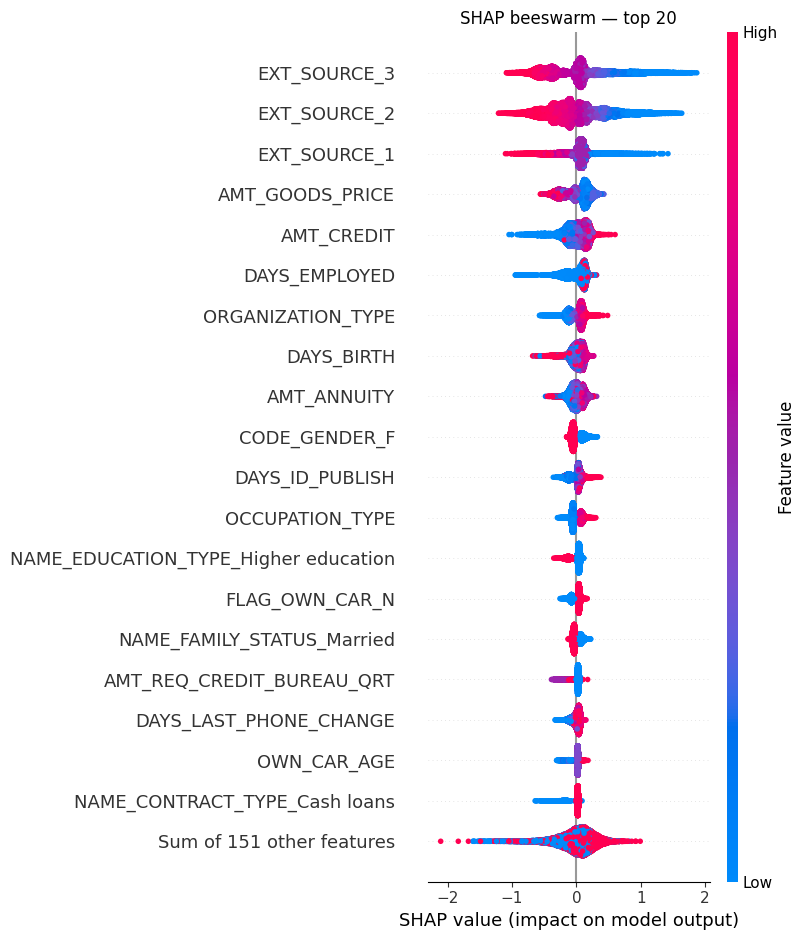

Saved: C:\Users\luizo\Projetos\credit-risk-model\artifacts\shap_beeswarm_top20.png


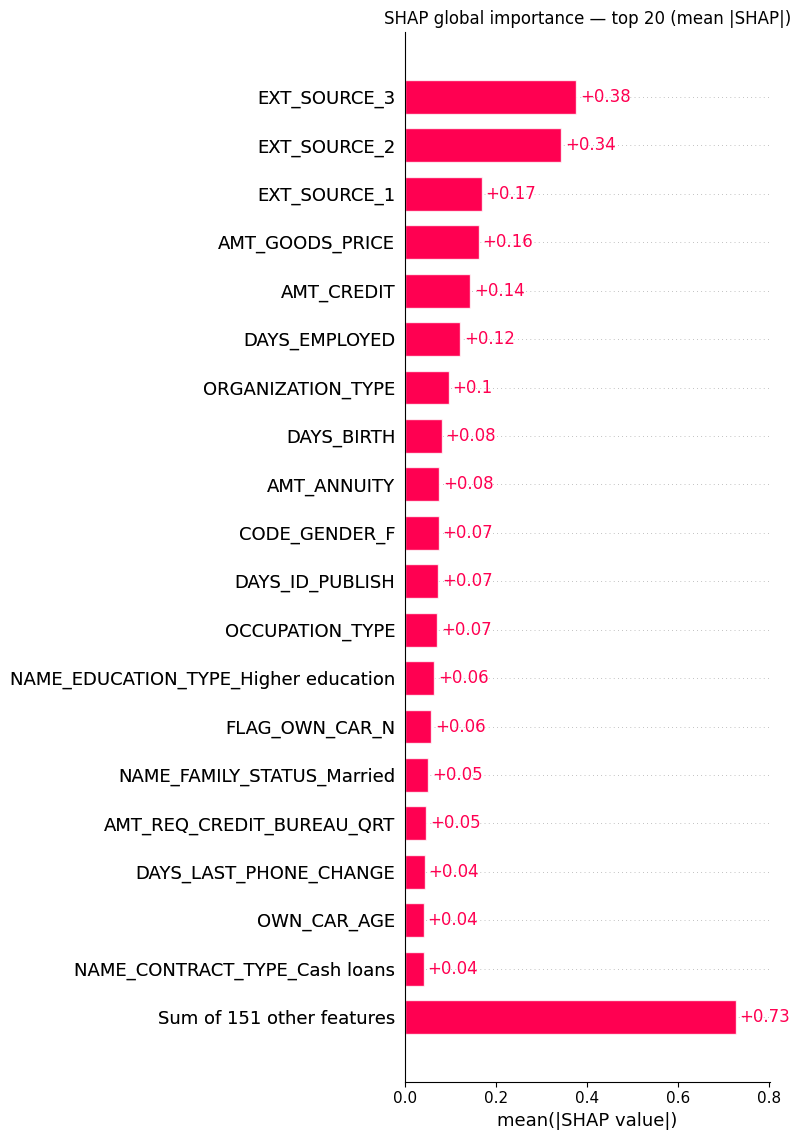

Saved: C:\Users\luizo\Projetos\credit-risk-model\artifacts\shap_bar_top20.png
Explaining SK_ID_CURR=112678
PD raw=0.9308 | PD calibrated=0.7500


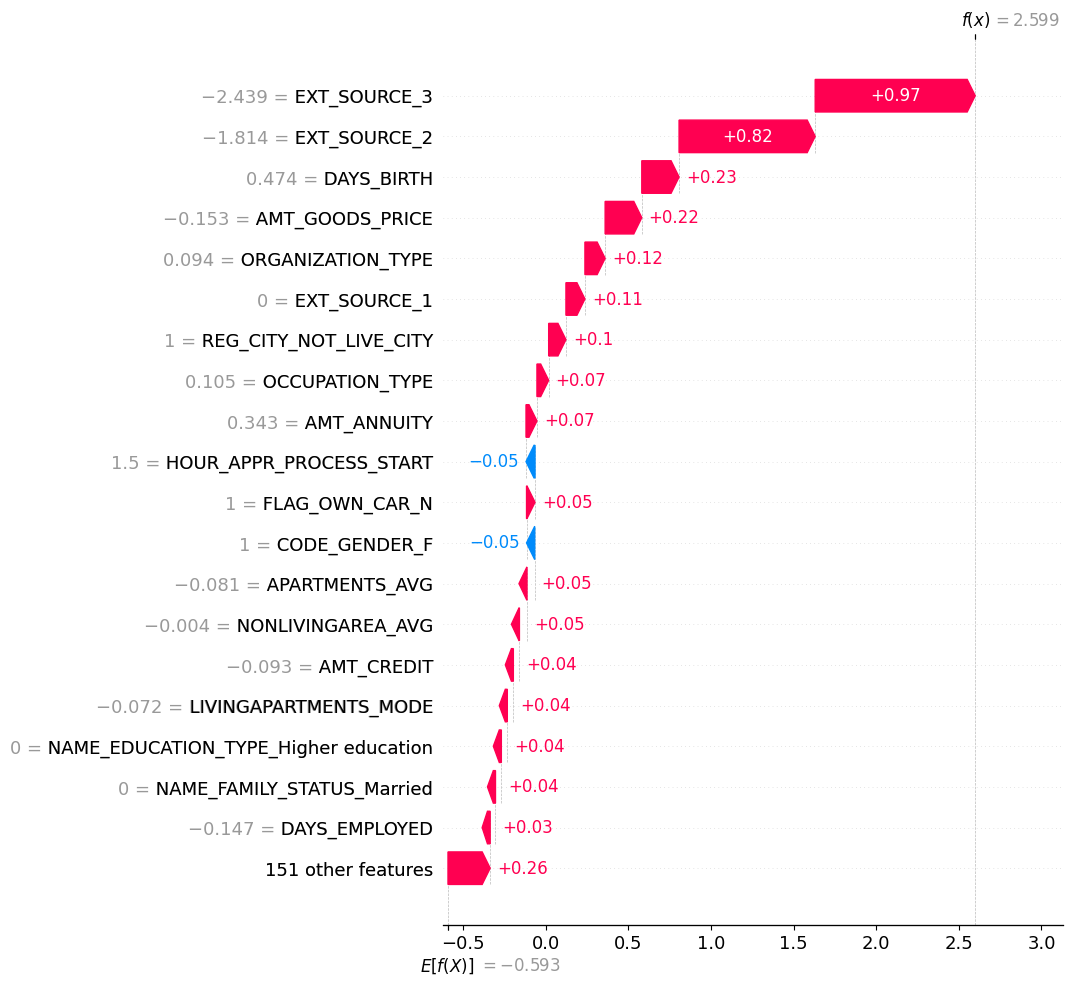

In [7]:
# ==================================
# SHAP — Global & Local explanations
# ==================================
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import sparse
import shap
import matplotlib.pyplot as plt

# 1) Carregar artefatos
prep   = joblib.load(ARTIFACTS / "preprocessor.joblib")
model  = joblib.load(ARTIFACTS / "lgbm_model.joblib")
iso    = joblib.load(ARTIFACTS / "isotonic.joblib")  # pode ser útil para escolher top-risk
try:
    feat_names = prep.get_feature_names_out().tolist()
except Exception:
    # fallback: tenta carregar do CSV salvo
    feat_names = pd.read_csv(ARTIFACTS / "feature_names_logreg.csv")["feature_name"].tolist()

# Transformar todo X (usaremos amostra para SHAP global)
Xt_all = prep.transform(X)
if sparse.issparse(Xt_all):
    Xt_all = Xt_all.toarray()

# 2) Amostra estratificada p/ SHAP global (rápido e representativo)
MAX_SAMPLES = 30000
sss = StratifiedShuffleSplit(n_splits=1, test_size=min(MAX_SAMPLES, len(X))/len(X), random_state=GLOBAL_SEED)
idx = next(sss.split(X, y))[1]  # indices do holdout (tamanho ~MAX_SAMPLES)
Xt_samp = Xt_all[idx]
y_samp  = y.iloc[idx].values

# Converter para DataFrame para preservar nomes nas figuras do SHAP
Xt_df = pd.DataFrame(Xt_samp, columns=feat_names)

# 3) TreeExplainer (LightGBM)
#    Funciona tanto com model quanto com model.booster_
explainer = shap.TreeExplainer(model)

# 4) SHAP values — estilo novo (Explanation)
#    check_additivity=False -> mais rápido e evita warnings em ensembles
sv = explainer(Xt_df, check_additivity=False)

# 5) Importância global (mean |SHAP|) e persistência
mean_abs = np.abs(sv.values).mean(axis=0)
imp_df = pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs}) \
           .sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
imp_path = ARTIFACTS / "shap_global_importance.csv"
imp_df.to_csv(imp_path, index=False)
print(f"Saved global importance → {imp_path}")

# 6) Plots globais (beeswarm + bar) e salvar
plt.figure(figsize=(9, 5))
shap.plots.beeswarm(sv, max_display=20, show=False)
plt.title("SHAP beeswarm — top 20")
plt.tight_layout()
beeswarm_path = ARTIFACTS / "shap_beeswarm_top20.png"
plt.savefig(beeswarm_path, dpi=160); plt.show()
print(f"Saved: {beeswarm_path}")

plt.figure(figsize=(7.5, 5))
shap.plots.bar(sv, max_display=20, show=False)
plt.title("SHAP global importance — top 20 (mean |SHAP|)")
plt.tight_layout()
bar_path = ARTIFACTS / "shap_bar_top20.png"
plt.savefig(bar_path, dpi=160); plt.show()
print(f"Saved: {bar_path}")

# 7) Explicação local — por SK_ID_CURR (ou top-risk da base)
def explain_customer(sk_id: int | None = None, max_display: int = 20):
    """
    Mostra waterfall SHAP para 1 cliente (por SK_ID_CURR).
    Se sk_id=None, escolhe o cliente com maior PD calibrada.
    """
    # Selecionar linha
    if sk_id is None:
        # usa maior PD calibrada
        pd_raw = model.predict_proba(Xt_all)[:, 1]
        pd_cal = iso.transform(pd_raw)
        i = int(np.argmax(pd_cal))
    else:
        # localizar índice pelo SK_ID_CURR
        pos = np.where(train["SK_ID_CURR"].values == sk_id)[0]
        if len(pos) == 0:
            raise ValueError(f"SK_ID_CURR {sk_id} not found in training data.")
        i = int(pos[0])

    x_row = Xt_all[i:i+1]  # 2D
    x_row_df = pd.DataFrame(x_row, columns=feat_names)

    # SHAP local
    sv1 = explainer(x_row_df, check_additivity=False)  # Explanation com 1 linha
    print(f"Explaining SK_ID_CURR={train.iloc[i]['SK_ID_CURR']}")
    print(f"PD raw={model.predict_proba(x_row)[0,1]:.4f} | PD calibrated={iso.transform(model.predict_proba(x_row)[:,1])[0]:.4f}")

    shap.plots.waterfall(sv1[0], max_display=max_display)

# Exemplo rápido: explica o top-risk
explain_customer(sk_id=None, max_display=20)


## SHAP Results  

#### 🔹 Global Feature Contributions  
- The **most important drivers** of credit default are the external risk scores `EXT_SOURCE_3`, `EXT_SOURCE_2`, and `EXT_SOURCE_1`, confirming their predictive strength.  
- Financial characteristics such as `AMT_GOODS_PRICE`, `AMT_CREDIT`, and `AMT_ANNUITY` also play a significant role in risk differentiation.  
- Demographic and employment-related features (`DAYS_EMPLOYED`, `DAYS_BIRTH`, `OCCUPATION_TYPE`) appear prominently, indicating that both financial profile and stability factors impact default risk.  
- Binary categorical indicators (e.g., `CODE_GENDER_F`, `FLAG_OWN_CAR_N`, `NAME_CONTRACT_TYPE_Cash loans`) add secondary but consistent contributions.  

#### 🔹 Global Interpretability — Insights  
- High values of `EXT_SOURCE_3` and `EXT_SOURCE_2` **decrease default probability**, while low values strongly **increase risk**, aligning with expectations (they are alternative credit bureau / behavioral scores).  
- Longer employment (`DAYS_EMPLOYED`) generally decreases risk, while instability in `OCCUPATION_TYPE` or younger age (`DAYS_BIRTH`) increases risk.  
- Larger credit amounts (`AMT_CREDIT`, `AMT_GOODS_PRICE`) are associated with higher risk, while higher annuities (`AMT_ANNUITY`) can act as stabilizing depending on income.  

#### 🔹 Local Interpretability — Example Case  
The waterfall plot shows how an individual applicant’s probability of default was constructed:  
- **Negative contributions (blue)**, such as high external scores, pushed the risk **down**.  
- **Positive contributions (red)**, such as lower income stability or specific categorical indicators, pushed the risk **up**.  
- The final prediction results from the **sum of all SHAP contributions**, providing a transparent explanation for this applicant’s credit decision.  

#### Takeaway  
SHAP confirms that the model’s behavior is consistent with domain knowledge: external risk scores, credit size, employment stability, and demographic factors are the strongest risk drivers. This enhances the **trustworthiness** of the model and ensures compliance with **explainability standards** (e.g., EBA/ECB requirements in Europe).


from pathlib import Path
import pandas as pd, joblib, json

ART = Path("artifacts")
assert (ART/"preprocessor.joblib").exists()
assert (ART/"lgbm_model.joblib").exists()
assert (ART/"isotonic.joblib").exists()
assert (ART/"thresholds_bands.json").exists()
assert (ART/"train_columns.csv").exists()

schema = pd.read_csv(ART/"train_columns.csv")["column"].tolist()
meta   = json.load(open(ART/"thresholds_bands.json"))

print("✔ schema cols:", len(schema))
print("✔ threshold:", meta["threshold"])
print("✔ bands:", [b["name"] for b in meta["bands"]["schema"]])


In [8]:
from pathlib import Path
import json, pandas as pd

REQUIRED = {
    "preprocessor": "preprocessor.joblib",
    "model":        "lgbm_model.joblib",
    "isotonic":     "isotonic.joblib",
    "schema":       "train_columns.csv",
    "bands":        "thresholds_bands.json",
}

def find_artifacts_dir() -> Path:
    """
    Procura a pasta de artifacts em locais prováveis:
    - ./artifacts                 (quando o notebook está na raiz)
    - ../artifacts                (quando o notebook está em notebooks/)
    - notebooks/artifacts         (legado)
    Retorna a primeira que contiver TODOS os arquivos REQUIRED.
    """
    cwd = Path.cwd()
    candidates = [
        cwd / "artifacts",
        cwd.parent / "artifacts",
        cwd / "notebooks" / "artifacts",
    ]
    for cand in candidates:
        if cand.exists():
            missing = [f for f in REQUIRED.values() if not (cand / f).exists()]
            if not missing:
                return cand
    # se nenhuma tem tudo, retorna a que mais tem (p/ diagnosticar melhor)
    best = None
    best_count = -1
    for cand in candidates:
        if cand.exists():
            count = sum((cand / f).exists() for f in REQUIRED.values())
            if count > best_count:
                best = cand; best_count = count
    if best is None:
        raise FileNotFoundError("Nenhuma pasta 'artifacts' encontrada nas localizações padrão.")
    else:
        missing = [f for f in REQUIRED.values() if not (best / f).exists()]
        raise FileNotFoundError(
            f"A pasta encontrada '{best}' não tem todos os arquivos: faltam {missing}.\n"
            f"Coloque os arquivos faltantes aí OU rode o notebook a partir da raiz do projeto."
        )

# === usar ===
ART = find_artifacts_dir()
print(f"✔ usando artifacts em: {ART}")

# sanity-check de conteúdo
schema_cols = pd.read_csv(ART / REQUIRED["schema"])["column"].tolist()
with open(ART / REQUIRED["bands"], "r") as f:
    meta = json.load(f)
bands_names = [b["name"] for b in meta["bands"]["schema"]]
print(f"✔ schema cols: {len(schema_cols)} | bands: {bands_names}")


✔ usando artifacts em: c:\Users\luizo\Projetos\credit-risk-model\artifacts
✔ schema cols: 120 | bands: ['Very Low', 'Low', 'Medium', 'Elevated', 'High', 'Very High']


In [9]:
import sys
from pathlib import Path

def add_project_root():
    here = Path.cwd()
    candidates = [here, here.parent, here.parent.parent]
    for p in candidates:
        if (p / "scripts").exists() and (p / "artifacts").exists():
            if str(p) not in sys.path:
                sys.path.insert(0, str(p))
            return p
    raise RuntimeError("Não encontrei a raiz do projeto contendo 'scripts' e 'artifacts'.")

PROJECT_ROOT = add_project_root()
print("✔ PROJECT_ROOT =", PROJECT_ROOT)

✔ PROJECT_ROOT = c:\Users\luizo\Projetos\credit-risk-model


In [10]:
from scripts.preprocess import load_artifacts, score_df

art = load_artifacts()  # usa artifacts/ (raiz do repo)
print("✔ Artifacts prontos para uso.")

# smoke-test pequeno (pega 5 linhas do holdout/test ou do train)
import pandas as pd
sample = pd.read_csv(r"C:\Users\luizo\Projetos\credit-risk-model\data\raw\application_test.csv").head(5)
scored = score_df(sample, art)
display(scored[["SK_ID_CURR", "pd_raw", "pd_calibrated", "band"]])


✔ Artifacts prontos para uso.
✔ Artifacts prontos para uso.


,SK_ID_CURR,pd_raw,pd_calibrated,band
0,100001,0.223547,0.026632,Medium
1,100005,0.597828,0.144587,Very High
2,100013,0.150509,0.017682,Low
3,100028,0.240369,0.031142,Medium
4,100038,0.591757,0.125000,Very High
